In [1]:
import numpy as np
import NegotiationTools as negtools
import matplotlib.pyplot as plt
from skimage.draw import rectangle
import skimage as skim
import pandas as pd
import seaborn as sb
import Experiments as exp
import math

stats = negtools.StatisticsLogger()
nt = negtools.NegTools()

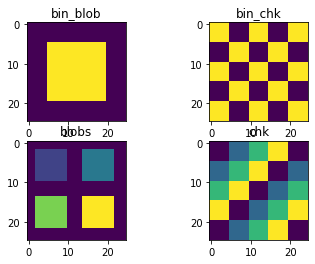

In [2]:
W = 25
H = 25
W2 = 5
H2 = 5
templates = dict()

templates['bin_blob'] = np.zeros((W, H), dtype=np.uint8)
templates['bin_blob'][tuple(rectangle(start=(5,5), extent=(15,15), shape=(W,H)))] = 1

templates['bin_chk'] = np.zeros((W, H), dtype=np.uint8)
is_one = True
for i in range(0,W,W2):
    for j in range(0,H,H2):
        if is_one is True:
            templates['bin_chk'][tuple(rectangle(start=(i,j), extent=(W2,H2), shape=(W,H)))] = 1
        is_one = not is_one
        
n_class = 4
blobs_w = 8
blobs_h = 8
w_off = 2
h_off = 2
blobs_val = 1

templates['blobs'] = np.zeros((W, H), dtype=np.uint8)
for i in range(0,W,blobs_w+2*w_off):
    for j in range(0,H,blobs_h+2*h_off):
        templates['blobs'][tuple(rectangle(start=(i+w_off,j+h_off), extent=(blobs_w,blobs_h), shape=(W,H)))] = blobs_val
        blobs_val = blobs_val+1

W = 25
H = 25
CHK_W = 5
CHK_H = 5
val = 0
n_class = 4
templates['chk'] = np.zeros((W, H), dtype=np.uint8)
is_one = True
for i in range(0,W,CHK_W):
    for j in range(0,H,CHK_H):
        templates['chk'][tuple(rectangle(start=(i,j), extent=(CHK_W,CHK_H), shape=(W,H)))] = val + 1
        val = (val + 1) % n_class

for i, (name, templ) in enumerate(templates.items()):
    plt.subplot(2, math.ceil(len(templates.items())/2), i+1)
    plt.imshow(templ)
    plt.title(name)

In [21]:
def agent_binary_balanced(mu, std):

    mu_mat = [[mu, 1.-mu],
           [1.-mu, mu]]
    std_mat = np.ones_like(mu_mat)*std
    return (np.asarray(mu_mat),np.asarray(std_mat))

def agent_binary_unbalanced(mu_1, mu_2, std):
    
    mu_mat = [[mu_1, 1.-mu_1],
           [1.-mu_2, mu_2]]
    std_mat = np.ones_like(mu_mat)*std
    return (np.asarray(mu_mat),np.asarray(std_mat))


def agent_expert(mu_star, mu, std, c_star, n_labels):
    '''
    :param mu_star - "competence" on expertise class
    :param mu - "competence" on non expertise classes
    :param std - standard deviation
    :param c_star - index of expertise class
    :param n_labels - number of labels
    '''
    samp_mu = np.random.normal(loc=mu, scale=std)
    samp_mu_star = np.random.normal(loc=mu_star, scale=std)
    samp_c_star_others = (1. - samp_mu_star)/(n_labels - 1.)
    samp_gamma = (1. - samp_c_star_others - samp_mu) / (n_labels-2.) if n_labels > 2 else 0

    mat = list()
    for t in range(n_labels):
        row = list()
        for p in range(n_labels):
            if p == c_star and t == c_star:
                row.append(samp_mu_star)
            elif t == c_star or p == c_star:
                row.append(samp_c_star_others)
            elif p == t:
                row.append(samp_mu)
            else:
                row.append(samp_gamma)
        mat.append(row)
    return np.asarray(mat)

def generate_predictions(gt_template, mu_matrix, std_matrix):
    prediction = list()
    # Iterating through the columns (predicted classes) of agent matrix, filling the corresponding ground_truth areas with predictions
    for pred_label in range(mu_matrix.shape[-1]):
        label_image = np.zeros_like(gt_template)
        for true_label in np.unique(gt_template):
            agent_labels = np.random.normal(loc=np.ones_like(gt_template)*mu_matrix[true_label, pred_label],scale=np.ones_like(gt_template)*std_matrix[true_label,pred_label])
            label_image = np.where(gt_template == true_label, agent_labels, label_image)
        prediction.append(label_image)
    prediction = np.stack(prediction, axis=-1)
    # Normalization
    prediction = np.clip(prediction, 0.0, 1.0)
    prediction = prediction / prediction.sum(axis=-1, keepdims=True) 
    return prediction

def generate_ground_truth(gt_template, n_labels):
    gt = list()
    for l in range(n_labels):
        gt_slice = np.where(gt_template==l, 1.0, 0.0)
        gt.append(gt_slice)
    return np.stack(gt, axis=-1)

## Experimental Design (Binary)

#### 1 balanced agent vs 2, 4, 8 unbalanced on C1

In [40]:
N_LABELS = 2
N_AGENTS = 3

mu = 0.75
std = 0.2
c_star = 0
template = templates['bin_blob']

# Generating agents
agents = [agent_binary_balanced(mu=mu, std=std) for a in range(N_AGENTS)]
# Generating ground truth and predictions
gt = generate_ground_truth(template, N_LABELS)
predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])

In [ ]:
template_name='bin_blob'
template = templates[template_name]
N_LABELS = 2
gt = generate_ground_truth(template, N_LABELS)
SAMPLES = 30
# Agents unbalanced on C1
log = pd.DataFrame()
for std in [0.01,0.05,0.1,0.2]:
    for unb_agents in [2, 4, 8]: 
        for mu_balanced in [.6, .75, .9]:
            for mu_1_unbalanced in [.6, .75, .9]:
                for mu_2_unbalanced in [0.4, 0.5]:
                    print("{} - 1 balanced agent (mu={}) vs {} unbalanced (mu1={}, mu2={}), noise std={}".format(template_name, mu_balanced, unb_agents, mu_1_unbalanced, mu_2_unbalanced, std) )
                    prediction_runs = list()
                    for i in range(SAMPLES):
                        balanced = agent_binary_balanced(mu=mu_balanced, std=std)
                        agents = [balanced] + [agent_binary_unbalanced(mu_1=mu_1_unbalanced, mu_2=mu_2_unbalanced, std=std) for a in range(unb_agents)]        
                        predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])
                        prediction_runs.append(predictions)
                    run_result = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES)
                    run_result['unbalanced_agents'] = unb_agents
                    run_result['mu_balanced'] = mu_balanced
                    run_result['mu_1_unbalanced'] = mu_1_unbalanced
                    run_result['mu_2_unbalanced'] = mu_2_unbalanced
                    run_result['std'] = std
                    log = log.append(run_result, ignore_index=True)

log.to_csv('results/{}_balanced_vs_unbalanced_c1.csv'.format(template_name))

In [ ]:
# Agents unbalanced on C2
log = pd.DataFrame()
for std in [0.01,0.05,0.1,0.2]:
    for unb_agents in [2, 4, 8]: 
        for mu_balanced in [.6, .75, .9]:
            for mu_1_unbalanced in [0.4, 0.5]:
                for mu_2_unbalanced in [.6, .75, .9]:
                    print("{} - 1 balanced agent (mu={}) vs {} unbalanced (mu1={}, mu2={}), noise std={}".format(template_name, mu_balanced, unb_agents, mu_1_unbalanced, mu_2_unbalanced, std) )
                    prediction_runs = list()
                    for i in range(SAMPLES):
                        balanced = agent_binary_balanced(mu=mu_balanced, std=std)
                        agents = [balanced] + [agent_binary_unbalanced(mu_1=mu_1_unbalanced, mu_2=mu_2_unbalanced, std=std) for a in range(unb_agents)]        
                        predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])
                        prediction_runs.append(predictions)
                    run_result = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES)
                    run_result['unbalanced_agents'] = unb_agents
                    run_result['mu_balanced'] = mu_balanced
                    run_result['mu_1_unbalanced'] = mu_1_unbalanced
                    run_result['mu_2_unbalanced'] = mu_2_unbalanced
                    run_result['std'] = std
                    log = log.append(run_result, ignore_index=True)

log.to_csv('results/{}_balanced_vs_unbalanced_c2.csv'.format(template_name))

In [46]:
# Half agents unbalanced on C1 and half on C2
log = pd.DataFrame()
for std in [0.01,0.05,0.1,0.2]:
    for unb_agents in [2, 4, 8]: 
        for mu_balanced in [.6, .75, .9]:
            for mu_1_unbalanced in [.6, .75, .9]:
                for mu_2_unbalanced in [0.4, 0.5]:
                    print("{} - 1 balanced agent (mu={}) vs {} unbalanced (mu1={}, mu2={}), noise std={}".format(template_name, mu_balanced, unb_agents, mu_1_unbalanced, mu_2_unbalanced, std) )
                    prediction_runs = list()
                    for i in range(SAMPLES):
                        balanced = agent_binary_balanced(mu=mu_balanced, std=std)
                        unbalanced_c1 = [agent_binary_unbalanced(mu_1=mu_1_unbalanced, mu_2=mu_2_unbalanced, std=std) for a in range(unb_agents//2)]
                        unbalanced_c2 = [agent_binary_unbalanced(mu_1=mu_2_unbalanced, mu_2=mu_1_unbalanced, std=std) for a in range(unb_agents//2)]
                        agents = [balanced] + unbalanced_c1 + unbalanced_c2
                        predictions = np.stack([generate_predictions(template, mu_matrix, std_matrix) for (mu_matrix, std_matrix) in agents])
                        prediction_runs.append(predictions)
                    run_result = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES)
                    run_result['unbalanced_agents'] = unb_agents
                    run_result['mu_balanced'] = mu_balanced
                    run_result['mu_1_unbalanced'] = mu_1_unbalanced
                    run_result['mu_2_unbalanced'] = mu_2_unbalanced
                    run_result['std'] = std
                    log = log.append(run_result, ignore_index=True)

log.to_csv('results/{}_balanced_vs_unbalanced_half.csv'.format(template_name))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


0     0.4
1     0.4
2     0.4
3     0.4
4     0.4
5     0.4
6     0.4
7     0.4
8     0.4
9     0.4
10    0.4
11    0.5
12    0.5
13    0.5
14    0.5
15    0.5
16    0.5
17    0.5
18    0.5
19    0.5
20    0.5
21    0.5
Name: mu_2_unbalanced, dtype: float64

In [5]:
c_star = 0
mu = 0.6
template = templates['bin_blob']
N_LABELS = 2
gt = generate_ground_truth(template, N_LABELS)
SAMPLES = 30
log = pd.DataFrame()
for unb_agents in [2, 4, 8]:
    for std in [0.01,0.05,0.1,0.2]:
        for mu_balanced in [.6, .75, .9]:
            # Balanced Agent
            balanced = agent_binary_balanced(mu=mu, std=std)

            for mu_1_unbalanced in [.6, .75, .9]:
                for mu_2_unbalanced in [0.4, 0.5]:
                    # Running "SAMPLES" times
                    prediction_runs = list()

                    for i in range(SAMPLES):
                        agents = [balanced] + [agent_binary_unbalanced(mu_1=mu_1_unbalanced, mu_2=mu_2_unbalanced, std=std) for a in range(unb_agents)]        
                        predictions = np.stack([generate_predictions(template, agent_matrix) for agent_matrix in agents])
                        prediction_runs.append(predictions)

                    results = exp.run_experiment_on_list(prediction_runs, [gt]*SAMPLES)
                    results['unbalanced_agents'] = unb_agents
                    results['mu_balanced'] = mu_balanced
                    results['mu_1_unbalanced'] = mu_1_unbalanced
                    results['mu_2_unbalanced'] = mu_2_unbalanced
                    results['std'] = std
                    log = log.append(results, ignore_index=True)
log.to_csv('results/binary_chk_balanced_vs_unbalanced_c1.csv'.format(std))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Consensus Reached at step, current step: 1
Sample 0 Con

KeyboardInterrupt: 